# MagNet: Model the Geomagnetic Field


This notebook describes a convolutional neural network approach to forecasting the disturbance storm time index. This is based on the second-place solution to a competition held by the National Oceanic and Atmospheric Association (NOAA) and National Aeronatics and Space Administration (NASA) in 2020-21 (https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/).

In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder

### Background on the geomagnetic field

The efficient transfer of energy from solar wind into the Earth’s magnetic field causes geomagnetic storms. The resulting variations in the magnetic field increase errors in magnetic navigation. The disturbance-storm-time index, or DST, is a measure of the severity of the geomagnetic storm.

As a key specification of the magnetospheric dynamics, the DST index is used to drive geomagnetic disturbance models such as NOAA/NCEI’s High Definition Geomagnetic Model - Real-Time (HDGM-**RT**). Additionally, magnetic surveyors, government agencies, academic institutions, satellite operators, and power grid operators use the DST index to analyze the strength and duration of geomagnetic storms.

Empirical models have been proposed as early as in 1975 to forecast DST solely from solar-wind observations at the Lagrangian (L1) position by satellites such as NOAA’s Deep Space Climate Observatory (DSCOVR) or NASA's Advanced Composition Explorer (ACE). Over the past three decades, several models were proposed for solar wind forecasting of DST, including empirical, physics-based, and machine learning approaches. While the ML models generally perform better than models based on the other approaches, there is still room to improve, especially when predicting extreme events. More importantly, we seek solutions that work on the raw, real-time data streams and are agnostic to sensor malfunctions and noise.

### Modelling task

The competition task was to develop models for forecasting DST that push the boundary of predictive performance, under operationally viable constraints, using the real-time solar-wind (RTSW) data feeds from NOAA’s DSCOVR and NASA’s ACE satellites. Improved models can provide more advanced warning of geomagnetic storms and reduce errors in magnetic navigation systems. Specifically, given one week of data ending at t minus 1 minute, the model must 
forecast DST at time t and t plus one hour.

### Data

The target DST values are measured by 4 ground-based observatories near the equator. These values are then averaged to provide a measurement of DST for any given hour.
To ensure similar distributions between the training and test data, the data is separated into three non-contiguous periods. All data are provided with a `period` and `timedelta` multi-index which indicates the relative timestep for each observation within a period, but not the real timestamp. The period identifiers and timedeltas are common across datasets.

There are 3 sources of input data:
* Measurements of the solar wind, including direction, speed, density and temperature, at 1-minute frequency.
* Position of the satellite used for solar wind measurements (this was not used in our solution, since we found it did not improve the model).
* Number of sunspots, measured monthly.

### Additional code

The code used here is available at: https://github.com/liyo6397/MagNet/. This repository also contains other notebooks and code for defining different model achitectures. The code is designed to be modular, so other architectures can 
easily be swapped for the one used here.



### Imports

The model is built with tensorflow, using the keras framework. We also use some common data science packages, including `numpy` and `pandas`, to prepare the data, and `matplotlib` for visualisation.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import datetime as dt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import time
import random
from typing import Callable, List, Optional, Tuple, Union
import tensorflow as tf
import matplotlib.pyplot as plt



### Download the data

All the competition data is now publically available. ``public.zip`` is the data that was provided for training in the competition. ``private.zip`` is the unseen data used for scoring. The private data was divided into 2 parts: some was used for a public leaderboard visible during the competition, and the remainder was used for the final ranking.

We will save the public and private data in separate directories, and use the public data for training and the private for validation, as in the competition.

In [2]:
%%capture
%%bash
#download the data
if [ ! -d "data" ]; then
  wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
  unzip public.zip
  wget https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
  unzip private.zip
  mkdir data
  mv public data
  mv private data
fi

In [3]:
# load dataframes from csv files
data_folder = "data"
solar_cols = ["period", "timedelta", "bx_gsm", "by_gsm", "bz_gsm", "bt", "speed", "density", "temperature"]
solar_train = pd.read_csv(os.path.join(data_folder, "public", "solar_wind.csv"), usecols=solar_cols, dtype={"period": "category"})
dst_train = pd.read_csv(os.path.join(data_folder, "public", "dst_labels.csv"), dtype={"period": "category"})
sunspots_train = pd.read_csv(os.path.join(data_folder, "public", "sunspots.csv"), dtype={"period": "category"})
solar_test = pd.read_csv(os.path.join(data_folder, "private", "solar_wind.csv"), usecols=solar_cols, dtype={"period": "category"})
dst_test = pd.read_csv(os.path.join(data_folder, "private", "dst_labels.csv"), dtype={"period": "category"})
sunspots_test = pd.read_csv(os.path.join(data_folder, "private", "sunspots.csv"), dtype={"period": "category"})

### Exploring the input data

The variables have very long-tailed distributions.



#### Distribution of features 

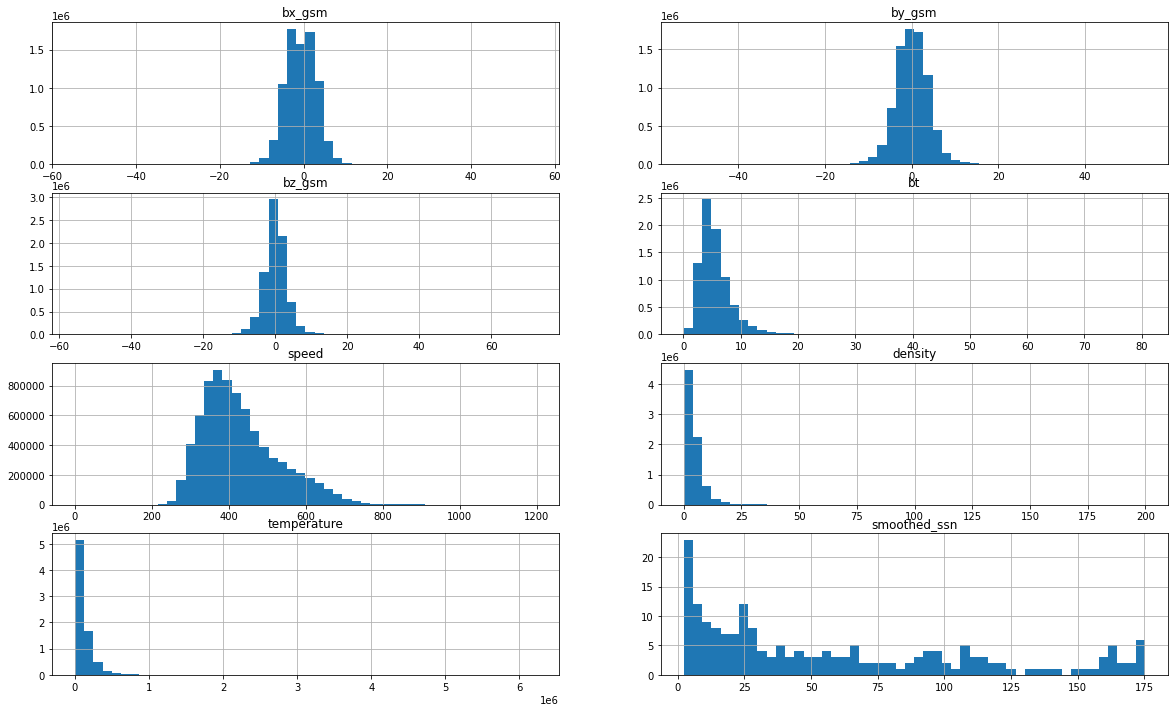

In [4]:
# plot distributions
fig, axs = plt.subplots(4, 2, figsize=(20, 12))
for i, var in enumerate(["bx_gsm", "by_gsm", "bz_gsm", "bt", "speed", "density", "temperature", "smoothed_ssn"]):
  plt.sca(axs.flat[i])
  if var == "smoothed_ssn":
    sunspots_train["smoothed_ssn"].hist(bins=50)
  else:
    solar_train[var].hist(bins=50)
  axs.flat[i].set_title(var)

#### Feature Correlation

<div class="alert alert-block alert-success"> For merge the pandas Dataframe, users can assign the approach to merge: 
left, right, outter, inner, cross. The approach is similar to the "join" function in SQL. In the following example, "left" means to preserve the key order and perform left outter join. </div>

<div class="alert alert-block alert-danger"> <b>Correlation matrix:</b>
Note that this is a slow command (several minutes) unless you have a GPU or TPU equivalent processor (then it's ~1 min).
Take advantage of Pandas DataFrame and merge our Input (Feature) and Output (Label) data.
i.e. merge, Solar Wind + Sunspots + Satellite Location + Dst</div>

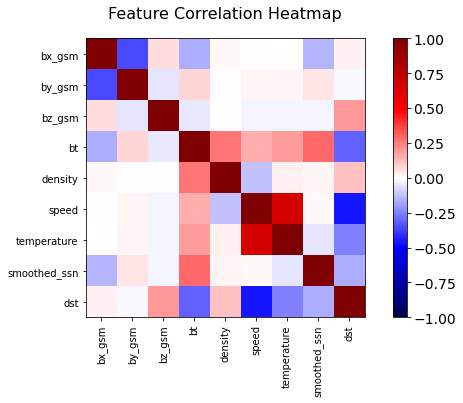

In [12]:
solar_sunspots = solar_train.merge(sunspots_train, how='left')
corr = solar_sunspots.merge(dst_train, how='left').fillna(method="ffill").corr()

plt.figure(figsize=(10, 5))
plt.matshow(corr, cmap='seismic', vmin=-1, vmax=1, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

del solar_sunspots
del corr

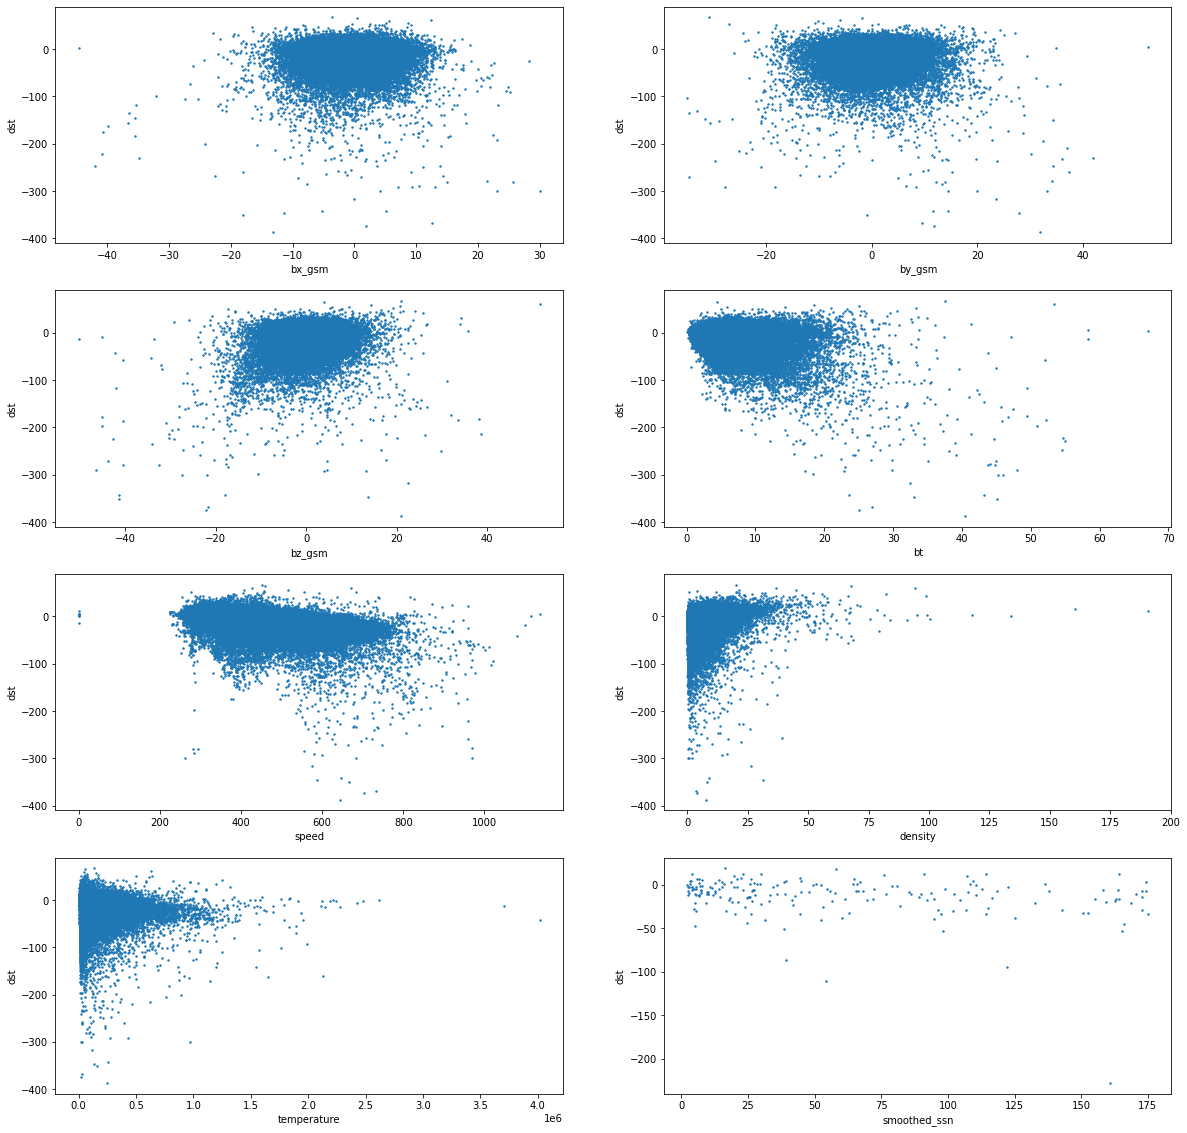

In [11]:
# plot correlations with dst
fig, axs = plt.subplots(4, 2, figsize=(20, 20))
for i, var in enumerate(["bx_gsm", "by_gsm", "bz_gsm", "bt", "speed", "density", "temperature", "smoothed_ssn"]):
  if var == "smoothed_ssn":
    df = dst_train.merge(sunspots_train[[var,"period", "timedelta"]], 'left', on=["period", "timedelta"])
  else:
    df = dst_train.merge(solar_train[[var,"period", "timedelta"]], 'left', on=["period", "timedelta"])
  axs.flat[i].scatter(df[var].values, df['dst'], s=2)
  axs.flat[i].set_ylabel('dst')
  axs.flat[i].set_xlabel(var)
del df

### Preprocessing

The model uses input data in the 
$(x, y, z)$ coordinate system, rather than the angular coordinate systems, so that the mean and standard deviation can be easily calculated. We use the GSM co-ordinate system, rather than GSE, since we found this gives better performance (see https://www.mssl.ucl.ac.uk/grid/iau/extra/local_copy/SP_coords/geo_sys.htm for details on these coordinate systems).

Periods where the temperature data is $< 1$ are excluded from the training data, since this is not physically realistic and suggests that sensors are malfunctioning. Missing data is filled 
by linear interpolation (to reduce noise, the interpolation uses a smoothed rolling average, 
rather than just the 2 points immediately
before and after the missing part).

Data is normalized by subtracting the median and dividing by the inter-quartile range (this approach is used rather 
than the more usual mean and standard deviation because some variables have asymmetric distributions with 
long tails).

To reduce the volume of data and the training time, data is aggregated  in 10-minute increments, taking the mean and standard deviation of each feature in 
the increment. This could alternatively be done as the first layer of the neural network, but it's more efficient 
to do it as a preprocessing step.


In [13]:
# function to preprocess data; we will use this to prepare the data for training 
# and validation

def prepare_data_1_min(
    solar: pd.DataFrame,
    sunspots: Union[pd.DataFrame, float],
    dst: pd.DataFrame = None,
    norm_df=None,
    output_folder: str = None,
    coord_system: str = "gsm",
    output_freq: str = "10_minute",
) -> Tuple[pd.DataFrame, List[str]]:
    """
    Prepare data for training or prediction, returning 10-minute aggregates.

    If ``dst`` is ``None``, prepare dataframe of feature variables only for prediction
    using previously-calculated normalization scaling factors in ``norm_df``.
    If ``dst`` is not ``None``, prepare dataframe of feature variables and labels for
    model training. Calculate normalization scaling factors and
    save in ``output_folder``. In this case ``output_folder`` must not be ``None``.

    Aggregate solar_data into 10-minute intervals and calculate the mean and standard
    deviation. Merge with sunspot data. Normalize the training data and save the scaling
    parameters in a dataframe (these are needed to transform data for prediction).

    This method modifies the input dataframes ``solar``, ``sunspots``, and ``dst``; if
    you want to keep the original dataframes, pass copies, e.g.
    ``prepare_data_1_min(solar.copy(), sunspots.copy(), dst.copy())``.

    Args:
        solar: DataFrame containing solar wind data. This function uses the GSM
            co-ordinates.
        sunspots: DataFrame containing sunspots data, or float. If dataframe, will be
            merged with solar data using timestamp. If float, all rows of output data
            will use this number.
        dst: ``None``, or DataFrame containing the disturbance storm time (DST) data,
        i.e. the labels for training
        norm_df: ``None``, or DataFrame containing the normalization scaling factors to
            apply
        output_folder: Path to the directory where normalisation dataframe will be saved
        coord_system: either "gsm" or "gse"
        output_freq: "10_minute" or "hour", how to aggregate the output data


    Returns:
        solar: DataFrame containing processed data and labels
        train_cols: list of training columns
    """

    if not os.path.exists(output_folder):
      os.mkdir(output_folder)

    # convert timedelta
    solar["timedelta"] = pd.to_timedelta(solar["timedelta"])

    # merge data
    solar["days"] = solar["timedelta"].dt.days
    if isinstance(sunspots, pd.DataFrame):
        sunspots["timedelta"] = pd.to_timedelta(sunspots["timedelta"])
        sunspots.sort_values(["period", "timedelta"], inplace=True)
        sunspots["month"] = list(range(len(sunspots)))
        sunspots["month"] = sunspots["month"].astype(int)
        sunspots["days"] = sunspots["timedelta"].dt.days
        solar = pd.merge(
            solar,
            sunspots[["period", "days", "smoothed_ssn", "month"]],
            "left",
            ["period", "days"],
        )
    else:
        solar["smoothed_ssn"] = sunspots
    solar.drop(columns="days", inplace=True)
    if dst is not None:
        dst["timedelta"] = pd.to_timedelta(dst["timedelta"])
        solar = pd.merge(solar, dst, "left", ["period", "timedelta"])
    solar.sort_values(["period", "timedelta"], inplace=True)
    solar.reset_index(inplace=True, drop=True)

    # remove anomalous data (exclude from training and fill for prediction)
    solar["bad_data"] = False
    solar.loc[solar["temperature"] < 1, "bad_data"] = True
    solar.loc[solar["temperature"] < 1, ["temperature", "speed", "density"]] = np.nan
    for p in solar["period"].unique():
        curr_period = solar["period"] == p
        solar.loc[curr_period, "train_exclude"] = (
            solar.loc[curr_period, "bad_data"].rolling(60 * 24 * 7, center=False).max()
        )

    # fill missing data
    if "month" in solar.columns:
        solar["month"] = solar["month"].fillna(method="ffill")
    if coord_system == "gsm":
        train_cols = [
            "bt",
            "density",
            "speed",
            "bx_gsm",
            "by_gsm",
            "bz_gsm",
            "smoothed_ssn",
        ]
    elif coord_system == "gse":
        train_cols = [
            "bt",
            "density",
            "speed",
            "bx_gse",
            "by_gse",
            "bz_gse",
            "smoothed_ssn",
        ]
    else:
        raise ValueError(f"Invalid coord system {coord_system}")
    train_short = [c for c in train_cols if c != "smoothed_ssn"]
    for p in solar["period"].unique():
        curr_period = solar["period"] == p
        solar.loc[curr_period, "smoothed_ssn"] = (
            solar.loc[curr_period, "smoothed_ssn"]
            .fillna(method="ffill", axis=0)
            .fillna(method="bfill", axis=0)
        )
        # fill short gaps with interpolation
        roll = (
            solar[train_short]
            .rolling(window=20, min_periods=5)
            .mean()
            .interpolate("linear", axis=0, limit=60)
        )
        solar.loc[curr_period, train_short] = solar.loc[
            curr_period, train_short
        ].fillna(roll)
        solar.loc[curr_period, train_short] = solar.loc[
            curr_period, train_short
        ].fillna(solar.loc[curr_period, train_short].mean(), axis=0)

    # normalize data using median and inter-quartile range
    if norm_df is None:
        norm_df = solar[train_cols].median().to_frame("median")
        norm_df["lq"] = solar[train_cols].quantile(0.25)
        norm_df["uq"] = solar[train_cols].quantile(0.75)
        norm_df["iqr"] = norm_df["uq"] - norm_df["lq"]
    if output_folder is not None:
        norm_df.to_csv(os.path.join(output_folder, "norm_df.csv"))
    solar[train_cols] = (solar[train_cols] - norm_df["median"]) / norm_df["iqr"]

    if dst is not None:
        # interpolate target and shift target since we only have data up to t - 1 minute
        solar["target"] = (
            solar["dst"].shift(-1).interpolate(method="linear", limit_direction="both")
        )
        # shift target for training t + 1 hour model
        solar["target_shift"] = solar["target"].shift(-60)
        solar["target_shift"] = solar["target_shift"].fillna(method="ffill")
        assert solar[train_cols + ["target", "target_shift"]].isnull().sum().sum() == 0

    # aggregate features
    if output_freq == "10_minute":
        win = 10
    elif output_freq == "hour":
        win = 60
    else:
        raise ValueError("output_freq must be 10_minute or hour.")
    new_cols = [c + suffix for suffix in ["_mean", "_std"] for c in train_short]
    train_cols = new_cols + ["smoothed_ssn"]
    new_df = pd.DataFrame(index=solar.index, columns=new_cols)
    for p in solar["period"].unique():
        curr_period = solar["period"] == p
        new_df.loc[curr_period] = (
            solar.loc[curr_period, train_short]
            .rolling(window=win, min_periods=1, center=False)
            .agg(["mean", "std"])
            .values
        )
        new_df.loc[curr_period] = (
            new_df.loc[curr_period].fillna(method="ffill").fillna(method="bfill")
        )
    solar = pd.concat([solar, new_df], axis=1)
    solar[train_cols] = solar[train_cols].astype(float)

    # sample at output frequency
    solar = solar.loc[solar["timedelta"].dt.seconds % (win * 60) == 0].reset_index()

    return solar, train_cols

### Model architecture

The model consists of a set of convolutional layers which detect patterns at progressively longer time spans. At each convolutional 
layer (except the last), a convolutional filter is applied having size 6 with stride 3, which reduces the size of the output data 
relative to the input. (The last convolution has small input size, so it just convolves all its 9 inputs 
together.) The earlier layers recognize low-level features on short time-spans, and these are outputs aggregated into higher-level
patterns spanning longer time ranges in the later layers. Cropping is applied at each layer which removes a few data points at the beginning at the 
sequence to ensure the result will be exactly divisible by 6, so that the last application of the convultional filter will 
capture the data at the very end of the sequence. Following all the convolutional 
layers is a layer which concatenates the last data point of each of the convolution outputs. This concatenation is then fed into a dense layer. The idea of taking the last data point of each convolution 
is that it represents the patterns  at different timespans leading up to the prediction time: for example, the last data point 
of the first layer gives the features of the hour before the prediction time, then the second layer gives 
the last 6 hours, etc.

The architecture is somewhat similar to a widely used architecture for image segmentation, the U-Net introduced by Ronneberger, Fischer, and Brox (https://arxiv.org/abs/1505.04597). The U-Net consists of a "contracting path", a series of convolutional layers which condense the image, followed by an "expansive path" of up-convolution layers which expand the outputs back to the scale of the original image. Combining small-scale and large-scale features allows the network to make localised predictions that also take account of larger surrounding patterns.

The idea is also similar to the Temporal Convolutional Network described by Bai, Kolter, and Koltun (https://arxiv.org/abs/1803.01271); however their architecture uses residual (i.e. additive) connections to blend the low-level and high-level features, rather than concatenations.


In [14]:
# define the model

def define_model_cnn_1_min() -> Tuple[
    tf.keras.Model, List[np.ndarray], int, float, int
]:
    """Define the structure of the neural network for 1-minute data
    Returns:
        model: keras model
        initial_weights: Array of initial weights used to reset the model to its
            original state
        epochs: Number of epochs
        lr: Learning rate
        bs: Batch size
    """

    inputs = tf.keras.layers.Input((6 * 24 * 7, 13))
    conv1 = tf.keras.layers.Conv1D(50, kernel_size=6, strides=3, activation="relu")(
        inputs
    )
    trim1 = tf.keras.layers.Cropping1D((5, 0))(
        conv1
    )  # crop from left so resulting shape is divisible by 6
    conv2 = tf.keras.layers.Conv1D(50, kernel_size=6, strides=3, activation="relu")(
        trim1
    )
    trim2 = tf.keras.layers.Cropping1D((1, 0))(conv2)
    conv3 = tf.keras.layers.Conv1D(30, kernel_size=6, strides=3, activation="relu")(
        trim2
    )
    trim3 = tf.keras.layers.Cropping1D((5, 0))(conv3)
    conv4 = tf.keras.layers.Conv1D(30, kernel_size=6, strides=3, activation="relu")(
        trim3
    )
    conv5 = tf.keras.layers.Conv1D(30, kernel_size=9, strides=9, activation="relu")(
        conv4
    )
    # extract last data point of previous convolutional layers (left-crop all but one)
    comb1 = tf.keras.layers.Concatenate(axis=2)(
        [
            conv5,
            tf.keras.layers.Cropping1D((334, 0))(conv1),
            tf.keras.layers.Cropping1D((108, 0))(conv2),
            tf.keras.layers.Cropping1D((34, 0))(conv3),
            tf.keras.layers.Cropping1D((8, 0))(conv4),
        ]
    )
    dense = tf.keras.layers.Dense(50, activation="relu")(comb1)
    output = tf.keras.layers.Flatten()(tf.keras.layers.Dense(1)(dense))
    model = tf.keras.Model(inputs, output)
    initial_weights = model.get_weights()
    epochs = 3
    lr = 0.00025
    bs = 32
    return model, initial_weights, epochs, lr, bs



### Ensembling

The final model is an ensemble of 5 models with the same structure, trained on different subsets of the data (these are often called "cross-validation folds"). This is a common technique in machine learning. The idea is that each model only imperfectly captures the "true" relationship betweeen the input and output variables, and partly fits to noise in the training data. But if we average several models, the random noise components will approximately cancel each other out, leaving a more accurate prediction of the true relationship.

The training data is segmented by month, and for each model 20\% of months are excluded. The data is split by months 
rather than hours because successive hours are likely to be correlated, meaning test and train sets would be 
more similar, reducing the benefit of the ensemble. Separate models are trained for times $t$ and $t+1$, yielding 10 models in total. To ensure each fold contains a mixture of extreme and moderate DST periods, we order the months by average DST, and then leave out every fifth month for each fold (e.g. in fold 0 we exclude months 4, 9, 14..., then in fold 1 we exclude months 1, 10, 15, ...).

<div class="alert alert-block alert-success">For reproducibility, we set the numpy, keras, and python random seeds. Results may still not reproduce exactly due to hardware differences. </div>

In [15]:
# define a function to automatically train an ensemble of models on different
# subsets of the data

def train_on_prepared_data(
    prepared_data: pd.DataFrame,
    model: tf.keras.Model,
    initial_weights: Union[List[List[np.ndarray]], List[np.ndarray]],
    epochs: int,
    lr: float,
    bs: int,
    train_cols,
    num_models: int = 1,
    output_folder: str = "trained_models",
    data_frequency: str = "minute",
    early_stopping: bool = False,
) -> Optional[List[float]]:
    """Train and save ensemble of models, each trained on a different subset of data.

    Args:
        prepared_data: DataFrame containing solar wind data, sunspots data, and labels
        model: keras neural network model,
        initial_weights: initial weights for the model. Either a single set of weights
            to use for all models, or a list of 2 * num_models sets of weights,
            representing weights for the t models followed by the t + 1 models.
        epochs: number of training epochs,
        lr: learning rate,
        bs: batch size,
        train_cols: columns of ``prepared_data`` to use for training. Must match the
            input size defined in ``model_definer``.
        num_models: Number of models to train.
        output_folder: Path to the directory where models will be saved
        data_frequency: frequency of the training data: "minute" or "hour"
        early_stopping: If ``True``, stop model training when validation loss stops
            decreasing.
    Returns:
        out-of-sample accuracy: If ``num_models > 1``, returns list of length
            ``num_models`` containing RMSE values for out-of-sample predictions for each
            model.
    """

    # define model and training parameters
    if data_frequency == "minute":
        sequence_length = 6 * 24 * 7
    else:
        sequence_length = 24 * 7

    oos_accuracy = []
    # train on sequences ending at the start of an hour
    valid_bool = prepared_data["timedelta"].dt.seconds % 3600 == 0
    # exclude periods where data contains nans
    nans_in_train = (
        prepared_data[train_cols]
        .isnull()
        .any(axis=1)
        .rolling(window=sequence_length + 1, center=False)
        .max()
    )
    valid_bool = valid_bool & (nans_in_train == 0)
    
    np.random.seed(0)
    random.seed(0)
    tf.random.set_seed(0)
    prepared_data["month"] = prepared_data["month"].astype(int)
    mean_dst_by_month = prepared_data.groupby("month")["target"].mean()
    mean_dst_by_month.sort_values(inplace=True)
    months = mean_dst_by_month.index
    # remove the first week from each period, because not enough data for prediction
    valid_ind_arr = []
    for p in prepared_data["period"].unique():
        all_p = prepared_data.loc[
            (prepared_data["period"] == p) & valid_bool
        ].index.values[24 * 7 :]
        valid_ind_arr.append(all_p)
    valid_ind = np.concatenate(valid_ind_arr)
    non_exclude_ind = prepared_data.loc[
        ~prepared_data["train_exclude"].astype(bool)
    ].index.values
    #np.random.shuffle(months)
    es_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    callbacks = []
    if early_stopping:
        callbacks.append(es_callback)
        epochs = 100
    for model_ind in range(num_models):
        if isinstance(initial_weights[0], np.ndarray):
            initial_weights_t = initial_weights
            initial_weights_t_plus_1 = initial_weights
        else:
            initial_weights_t = initial_weights[model_ind]
            initial_weights_t_plus_1 = initial_weights[num_models + model_ind]
        # t model
        tf.keras.backend.clear_session()
        model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        model.set_weights(initial_weights_t)
        if (num_models > 1) or early_stopping:
            # define train and test sets
            month_freq = num_models if num_models > 1 else 5
            # leave out every month_freq month; since months are ordered, these are approximately
            # evenly distributed among the range of dst values
            leave_out_months = months[model_ind :: month_freq]
            leave_out_months_ind = prepared_data.loc[
                valid_bool & prepared_data["month"].isin(leave_out_months)
            ].index.values
            curr_months_ind = prepared_data.loc[
                valid_bool & (~prepared_data["month"].isin(leave_out_months))
            ].index.values
            train_ind = np.intersect1d(
                np.intersect1d(valid_ind, curr_months_ind), non_exclude_ind
            )
            test_ind = np.intersect1d(valid_ind, leave_out_months_ind)
            train_gen = DataGen(
                prepared_data[train_cols].values,
                train_ind,
                prepared_data["target"].values.flatten(),
                bs,
                sequence_length,
            )
            test_gen = DataGen(
                prepared_data[train_cols].values,
                test_ind,
                prepared_data["target"].values.flatten(),
                bs,
                sequence_length,
            )
            model.fit(
                train_gen,
                validation_data=test_gen,
                epochs=epochs,
                verbose=1,
                callbacks=callbacks,
            )
            oos_accuracy.append(model.evaluate(test_gen, verbose=2)[1])
            print("Out of sample accuracy: ", oos_accuracy)
            print("Out of sample accuracy mean: {}".format(np.mean(oos_accuracy)))
        else:
            # fit on all data
            train_ind = valid_ind
            train_gen = DataGen(
                prepared_data[train_cols].values,
                train_ind,
                prepared_data["target"].values.flatten(),
                bs,
                sequence_length,
            )
            model.fit(train_gen, epochs=epochs, verbose=1, callbacks=callbacks)
        model.save(os.path.join(output_folder, "model_t_{}.h5".format(model_ind)))
        if early_stopping:
            with open(os.path.join(output_folder, "log.txt"), "a") as f:
                es_iter = es_callback.stopped_epoch - es_callback.patience + 1
                f.write(f"\n\nEarly stopping iterations: {es_iter}")
        # t + 1 model
        tf.keras.backend.clear_session()
        model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        model.set_weights(initial_weights_t_plus_1)
        data_gen = DataGen(
            prepared_data[train_cols].values,
            train_ind,
            prepared_data["target_shift"].values.flatten(),
            bs,
            sequence_length,
        )
        if early_stopping and (es_callback.stopped_epoch > 0):
            model.fit(
                data_gen,
                epochs=es_callback.stopped_epoch - es_callback.patience + 1,
                verbose=1,
            )
        else:
            model.fit(data_gen, epochs=epochs, verbose=1)
        model.save(
            os.path.join(output_folder, "model_t_plus_one_{}.h5".format(model_ind))
        )
    if num_models > 1:
        return oos_accuracy

### Data generator

We make a data generator to generate batches of input data and labels to feed to the keras model. Generating the data dynamically this way saves memory by avoiding the need to assemble all the data in a large array before training. (This large array would consume much more memory than the original data, because there is a lot of overlap in input data between subsequent prediction times, and thus a lot of repetition of the input data). Data is shuffled at the end of each training epoch, so each epoch's batches are different.

In [16]:
# define data generator

class DataGen(tf.keras.utils.Sequence):
    """Data generator to dynamically generate batches of training data for keras model.
    Each batch consists of multiple time series sequences.

    See the keras documentation for more details:
    https://keras.io/getting_started/faq/#what-do-sample-batch-and-epoch-mean
    """

    def __init__(
        self,
        x: np.ndarray,
        valid_inds: np.ndarray,
        y: Optional[np.ndarray] = None,
        batch_size: int = 32,
        length: int = 24 * 6 * 7,
        shuffle: bool = True,
    ):
        """Construct the data generator.

        If ``y`` is not ``None``, will generate batches of pairs of x and y data,
        suitable for training. If ``y`` is ``None``, will generate batches of ``x``
        data only, suitable for prediction.

        ``x`` and ``y`` data must already be ordered by period and time. The training
        sample generated for an index ``i`` in ``valid_ind`` will have target ``y[i]``
        and ``x`` variables from rows ``(i - length + 1)`` to ``i`` (inclusive) of
        ``x``.  If there are multiple periods, there should be at least ``(length - 1)``
        data points before the first ``valid_ind`` in each period, otherwise the
        sequence for that valid_ind will include data from a previous period.

        Args:
            x: Array containing the x variables ordered by period and time
            y: ``None`` or array containing the targets corresponding to the ``x``
                variables
            batch_size: Size of training batches
            valid_inds: Array of ``int`` containing the indices which are valid
                end-points of training sequences (for example, we may set ``valid_inds``
                so it contains only the data points at the start of each hour).
            length: Number of data points in each sequence of the batch
            shuffle: Whether to shuffle ``valid_ind`` before training and after
                each epoch. For training, it is recommended to set this to ``True``, so
                each batch contains a varied sample of data from different times. For
                prediction, it should be set to ``False``, so that the predicted values
                are in the same order as the input data.
        """

        self.x = x
        self.y = y
        self.length = length
        self.batch_size = batch_size
        self.valid_inds = np.copy(valid_inds)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.valid_inds)

    def __get_y__(self):
        """Return the array of labels indexed by ``valid_ind``."""
        if self.y is None:
            raise RuntimeError("Generator has no y data.")
        else:
            return self.y[self.valid_inds]

    def __len__(self):
        """Return the number of batches in each epoch."""
        return int(np.ceil(len(self.valid_inds) / self.batch_size))

    def __getitem__(self, idx):
        """Generate a batch. ``idx`` is the index of the batch in the training epoch."""
        if (idx < self.__len__() - 1) or (len(self.valid_inds) % self.batch_size == 0):
            num_samples = self.batch_size
        else:
            num_samples = len(self.valid_inds) % self.batch_size
        x = np.empty((num_samples, self.length, self.x.shape[1]))
        end_indexes = self.valid_inds[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        for n, i in enumerate(end_indexes):
            x[n] = self.x[i - self.length : i, :]
        if self.y is None:
            return x
        else:
            y = self.y[end_indexes]
            return x, y

    def on_epoch_end(self):
        """Code to run at the end of each training epoch."""
        if self.shuffle:
            np.random.shuffle(self.valid_inds)



### Train the model

Here we execute the data preparation and training functions we defined earlier.

In [17]:
# prepare data
output_folder = "trained_models_cnn"
solar_1_min, train_cols = prepare_data_1_min(
    solar_train, sunspots_train, dst_train, output_folder=output_folder, norm_df=None
)

In [ ]:
# train model
model_def_1_min = define_model_cnn_1_min
model, initial_weights, epochs, lr, bs = model_def_1_min()
train_on_prepared_data(
        solar_1_min,
        model,
        initial_weights,
        epochs,
        lr,
        bs,
        train_cols,
        5,
        output_folder,
        "minute",
        False
    )

Epoch 1/3
3466/3466 [==============================] - 167s 48ms/step - loss: 103.0521 - root_mean_squared_error: 10.1515 - val_loss: 94.8919 - val_root_mean_squared_error: 9.7413
Epoch 2/3
3466/3466 [==============================] - 169s 49ms/step - loss: 74.0961 - root_mean_squared_error: 8.6079 - val_loss: 89.5618 - val_root_mean_squared_error: 9.4637
Epoch 3/3
3466/3466 [==============================] - 166s 48ms/step - loss: 64.6301 - root_mean_squared_error: 8.0393 - val_loss: 87.3852 - val_root_mean_squared_error: 9.3480
885/885 - 11s - loss: 87.3852 - root_mean_squared_error: 9.3480 - 11s/epoch - 12ms/step
Out of sample accuracy:  [9.348004341125488]
Out of sample accuracy mean: 9.348004341125488
Epoch 1/3
3466/3466 [==============================] - 155s 44ms/step - loss: 106.4496 - root_mean_squared_error: 10.3174
Epoch 2/3
3466/3466 [==============================] - 156s 45ms/step - loss: 78.1723 - root_mean_squared_error: 8.8415
Epoch 3/3
3466/3466 [=====================

### Load Models

In [18]:
# define function to load saved models

def load_models(
    input_folder: str, num_models: int,
) -> Tuple[List[tf.keras.Model], List[tf.keras.Model], pd.DataFrame]:
    """Define the model structure and load the saved weights of the trained models.

    Args:
        input_folder: Path to location where model weights are saved
        num_models: Number of models trained for each of ``t`` and ``t + 1`` (total
            number of models in folder should be ``2 * num_models``)

    Returns:
        model_t_arr: List of models for time ``t``
        model_t_plus_one_arr: List of models for time ``t + 1``
        norm_df: DataFrame of scaling factors to normalize the data
    """
    model_t_arr = []
    model_t_plus_one_arr = []
    for i in range(num_models):
        model = tf.keras.models.load_model(
            os.path.join(input_folder, "model_t_{}.h5".format(i))
        )
        model_t_arr.append(model)
        model = tf.keras.models.load_model(
            os.path.join(input_folder, "model_t_plus_one_{}.h5".format(i))
        )
        model_t_plus_one_arr.append(model)
    norm_df = pd.read_csv(os.path.join(input_folder, "norm_df.csv"), index_col=0)
    return model_t_arr, model_t_plus_one_arr, norm_df

In [19]:
model_t_arr, model_t_plus_1_arr, norm_df = load_models(output_folder, 1)
dst_test["timedelta"] = pd.to_timedelta(dst_test["timedelta"])
# exclude times in the first week + 1 hour of dst_test
dst_test = dst_test.loc[dst_test["timedelta"] >= dt.timedelta(days=7, hours=1)].copy()

OSError: ignored

### Measure overall performance

We score the model on the private dataset, using the root mean squared error metric used in the competition. In the competition, the prediction function was called repeatedly on one week of input data at at time. Here we can speed up the prediction by using the data generator we defined above.

In [10]:
# define prediction function

def predict_batch(
    solar: pd.DataFrame,
    sunspots: pd.DataFrame,
    prediction_times: pd.DataFrame,
    model_t_arr: List[tf.keras.Model],
    model_t_plus_one_arr: List[tf.keras.Model],
    norm_df: pd.DataFrame,
    frequency: str,
    output_folder: str,
    comb_model: bool = False
) -> Tuple[pd.DataFrame, List, List]:
    """
    Make predictions for multiple times; faster than ``predict_one_time``.

    Input data must be sorted by period and timT and have 1-minute frequency, and there
    must be at least 1 week of data before the first prediction time.

    Args:
        solar: DataFrame containing solar wind data
        sunspots: DataFrame containing sunspots data
        prediction_times: DataFrame with a single column `timedelta` for which to make
            predictions. For each value ``t``, return predictions for ``t`` and
            ``t`` plus one hour.
        model_t_arr: List of models for time ``t``
        model_t_plus_one_arr: List of models for time ``(t + 1)``
        norm_df: Scaling factors to normalize the data
        frequency: frequency of the model, "minute", "hour" or "hybrid"
        output_folder: Path to the directory where normalisation dataframe will be saved
        comb_model: if ``True`` assumes a single model that predicts ``t`` and ``t+1``

    Returns:
        predictions: DataFrame with columns ``timedelta``, ``period``, ``prediction_t``
            and ``prediction_t_plus_1``
    """

    # validate input data
    solar["timedelta"] = pd.to_timedelta(solar["timedelta"])
    diff = solar["timedelta"].diff()
    diff.loc[solar["period"] != solar["period"].shift()] = np.nan
    valid_diff = solar["period"] == solar["period"].shift(1)
    if (frequency in ["minute", "hybrid"]) and np.any(
        diff.loc[valid_diff] != dt.timedelta(minutes=1)
    ):
        raise ValueError(
            "Input data must be sorted by period and time and have 1-minute frequency."
        )
    elif (frequency == "hour") and np.any(
        diff.loc[valid_diff] != dt.timedelta(hours=1)
    ):
        raise ValueError(
            "Input data must be sorted by period and time and have 1-hour frequency."
        )

    # add column to solar to indicate which times we must predict
    prediction_times["prediction_time"] = True
    solar = pd.merge(solar, prediction_times, on=["period", "timedelta"], how="left")
    solar["prediction_time"] = solar["prediction_time"].fillna(False)
    solar.sort_values(["period", "timedelta"], inplace=True)
    solar.reset_index(inplace=True, drop=True)

    # prepare data
    if frequency == "minute":
        solar, train_cols = prepare_data_1_min(
            solar.copy(), sunspots.copy(), output_folder=output_folder, norm_df=norm_df
        )
    elif frequency == "hour":
        solar, train_cols = prepare_data_hourly(
            solar.copy(), sunspots.copy(), norm_df=norm_df
        )
    elif frequency == "hybrid":
        solar, train_cols = prepare_data_hybrid(
            solar.copy(), None, sunspots.copy(), norm_df=norm_df, freq_for_1_min_data="10_minute"
        )
    else:
        raise ValueError(f"Invalid frequency {frequency}")

    # check there is 1 week of data before each valid time
    min_data_by_period = solar.groupby("period")["timedelta"].min().to_frame("min_time")
    min_data_by_period["min_prediction_time"] = (
        solar.loc[solar["prediction_time"]].groupby("period")["timedelta"].min()
    )
    min_data_by_period["data_before_first_prediction"] = (
        min_data_by_period["min_prediction_time"] - min_data_by_period["min_time"]
    )
    if min_data_by_period["data_before_first_prediction"].min() < dt.timedelta(days=7):
        raise RuntimeError(
            "There must be at least 1 week of data before the first prediction time in each period."
        )

    # valid_ind will be the endpoints of the sequences generated by the data generator;
    # these must be 1 minute/hour before the prediction time
    solar["valid_ind"] = solar["prediction_time"].fillna(False)

    # make prediction
    predictions = pd.DataFrame(prediction_times[["timedelta", "period"]].copy())
    valid_ind = solar.loc[solar["valid_ind"]].index.values
    sequence_length = 24 * 6 * 7 if frequency in ["minute", "hybrid"] else 24 * 7
    datagen = DataGen(
        solar[train_cols].values,
        valid_ind,
        y=None,
        batch_size=100,
        length=sequence_length,
        shuffle=False,
    )

    #Create the array for analyzing five models later.
    t0_predictions_set = []
    t1_predictions_set = []

    predictions["prediction_t"] = 0
    predictions["prediction_t_plus_1"] = 0
    if comb_model:
        for m in model_t_arr:
            predictions[["prediction_t", "prediction_t_plus_1"]] = np.array(m.predict(datagen))
    else:
        for m in model_t_arr:
            curr_model = np.array(m.predict(datagen)).flatten()
            t0_predictions_set.append(curr_model)
            predictions["prediction_t"] += curr_model
        predictions["prediction_t"] /= len(model_t_arr)

        for m in model_t_plus_one_arr:
            curr_model = np.array(m.predict(datagen)).flatten()
            t0_predictions_set.append(curr_model)
            predictions["prediction_t_plus_1"] += curr_model
        predictions["prediction_t_plus_1"] /= len(model_t_plus_one_arr)

    # restrict to allowed range
    predictions["prediction_t"] = np.maximum(
        -2000, np.minimum(500, predictions["prediction_t"])
    )
    predictions["prediction_t_plus_1"] = np.maximum(
        -2000, np.minimum(500, predictions["prediction_t_plus_1"])
    )

    return predictions, t0_predictions_set, t1_predictions_set


In [26]:
# measure performance
predictions, t0_predictions_set, t1_predictions_set = predict_batch(
    solar_test.copy(), sunspots_test, dst_test, model_t_arr, model_t_plus_1_arr, norm_df, "minute", output_folder
)

dst_test_1_min = pd.merge(dst_test, predictions, "left", ["timedelta", "period"])
dst_test_1_min["dst_t_plus_1"] = dst_test_1_min.groupby("period")["dst"].shift(-1)
aveModel_rmse_t = np.sqrt(
    mean_squared_error(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values)
)
valid_ind = dst_test_1_min["dst_t_plus_1"].notnull()
aveModel_rmse_t_plus_1 = np.sqrt(
    mean_squared_error(
        dst_test_1_min.loc[valid_ind, "dst_t_plus_1"].values,
        dst_test_1_min.loc[valid_ind, "prediction_t_plus_1"].values,
    )
)
print(f"RMSE for time t: {aveModel_rmse_t:0.2f}")
print(f"RMSE for time t+1: {aveModel_rmse_t_plus_1:0.2f}")

RMSE for time t: 12.30
RMSE for time t+1: 11.62


### Analyze model uncertainty

The final model is an ensemble of 5 models with the same structure, trained on different cross-validation folds. To understand the uncertainty of 5 models, we use errorbar to indicate the spreads of 5 models. The limits is the maximum and minimum difference of predicted Dst with final model's Dst in each time steps.

In our case, the size of ensamble is various in each time steps. The larger the peak intends to have the larger spreads.

In [12]:
# define the function for selecting the max and min difference based in each time steps for each five models
def creat_model_uncertainty_array(N: int, predictions_set: List, ave_predictions_set: List):
    uncertainty = []
    for j in range(N):
        tmp_arr = []
        for i in range(len(predictions_set)):
            tmp_arr.append(predictions_set[i][j] - ave_predictions_set[j])
        max_val = np.max(tmp_arr)
        min_val = np.min(tmp_arr)
        uncertainty.append(max_val - min_val)

    return uncertainty


In [13]:
# define the functions for selecting data points by frequency
def select_by_freq(true_dst: np.ndarray, predict_dst: np.ndarray, uncertainty: List, freq: int) -> Tuple[np.ndarray, np.ndarray,  np.ndarray,  np.ndarray]:

    time = []
    true = []
    pred = []
    predErr = []

    i = 0
    while i < len(true_dst):
        time.append(i)
        true.append(true_dst[i])
        pred.append(predict_dst[i])
        predErr.append(uncertainty[i])
        i += freq

    time = np.array(time, dtype=float)
    true = np.array(true, dtype=float)
    pred = np.array(pred, dtype=float)
    predErr = np.array(predErr, dtype=float)

    return time, true, pred, predErr



In [19]:
# define the function to plot Errorbar for each model
def plot_ErrorBar(true_dst: np.ndarray, predict_dst: np.ndarray, uncertainty: List, freq: int):

    plt.figure(figsize=(12, 9))

    time, true, pred, predErr = select_by_freq(true_dst, predict_dst, uncertainty, freq)

    plt.plot(time, true, color="r", label="true data")
    plt.errorbar(time, pred, predErr, color="b", label="limits of predicted Dst", elinewidth = 2)

    plt.style.use('seaborn-whitegrid')
    plt.title("Uncertainty Quantification(UQ) of the Ensamble CNN Model")
    plt.legend(loc='lower right')
    plt.xlabel("hours")
    plt.ylabel("Dst")
    plt.show()
    


#### Visulize the Error Bar
The error bar indicates the maximum and minimum Dst value predicted by five models. 

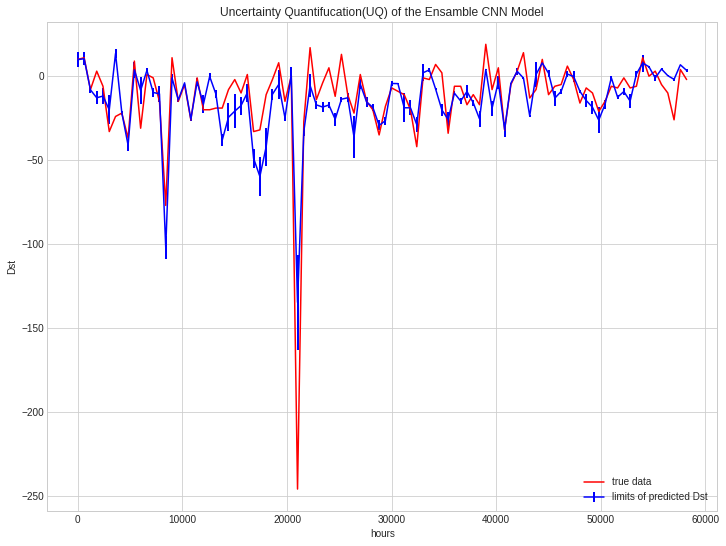

In [20]:
# plot the limits for the prediction model
N = len(predictions)
t0_uncern = creat_model_uncertainty_array(N, t0_predictions_set, predictions["prediction_t"].values)
time_arr = dst_test["timedelta"].values

# Assign the number of frequency to plot the error bar.
freq = 600
plot_ErrorBar(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values, t0_uncern, freq)

### Explainable AI(XAI)

The idea is to evaluate the importance of feature to the model. Based on Christoph Molnar's "Interpretable Machine Learning" section and Fisher, Rudin, and Dominici (2018), if the feature is important, after permuting the feature e.g. split, swap or shuffling, the model error will increase. On the vice-versa, if the feature is unimportant, it leaves the model error almost unchanged.  


Resources:
*   Christoph Molnar's "Interpretable Machine Learning" section on [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), and see also their <b>argument for using Test data</b> for Permutation Importance evaluation, which we have chosen to do here.
*   [See this illustrative graphic demonstrating single- and multi-pass Permutation Importance](https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance)
*   [Permutation Feature Importance in the <i>scikit-learn</i> module](https://scikit-learn.org/stable/modules/permutation_importance.html)

Basically, we can split and swap the feature datasets one feature at a time and compare the resultant RMSE. We take a programming convenience shortcut and <b>simply reverse each feature</b> vector rather than split and swap and we expect the same results. We'll do this, i.e. permute each feature vector, one at a time. Then, calcualte the ratio of RMSE with the RMSE without permuting features which we computed at previous section. 

In [27]:
def permutation_importance(solar: pd.DataFrame,
    sunspots: pd.DataFrame,
    dst: pd.DataFrame,
    model_t_arr: List[tf.keras.Model],
    model_t_plus_one_arr: List[tf.keras.Model],
    norm_df: pd.DataFrame,
    train_cols: List,
    output_folder: str) -> pd.DataFrame:

    rmse_permute_df = pd.DataFrame(np.zeros((1, len(train_cols))), columns=train_cols)

    for feature in train_cols:

        test_for_permute = solar.copy(deep=True)
        # Approximate split permutation by simply reversing the data in this feature
        test_for_permute[feature].values[:] = test_for_permute[feature].values[::-1]

        print(f"feature: {feature}")
        # get prediction
        predictions, t0_predictions_set, t1_predictions_set = predict_batch(
            test_for_permute, sunspots, dst, model_t_arr, model_t_plus_one_arr, norm_df, "minute", output_folder
        )


        dst_test_1_min = pd.merge(dst, predictions, "left", ["timedelta", "period"])

        loss_t = np.sqrt(
            mean_squared_error(dst_test_1_min["dst"].values, dst_test_1_min["prediction_t"].values)
        )

        rmse_permute_df[feature] = loss_t

        print('%s: %f rmse nano-Tesla' % (feature, rmse_permute_df[feature]))

        del predictions
        del t0_predictions_set
        del t1_predictions_set

    return rmse_permute_df



In [28]:
#Delete the predictions results to avoid running out of RAM
del predictions
del t0_predictions_set
del t1_predictions_set

# define the features plans to permute
permute_cols = ["bx_gsm", "by_gsm", "bz_gsm", "bt", "speed", "density", "temperature"] 

rmse_permute_df = permutation_importance(solar_test.copy(), sunspots_test, dst_test, 
                                         model_t_arr, model_t_plus_1_arr, norm_df, permute_cols, output_folder)


feature: bx_gsm
bx_gsm: 14.191496 rmse nano-Tesla
feature: by_gsm
by_gsm: 14.936109 rmse nano-Tesla
feature: bz_gsm
bz_gsm: 21.602633 rmse nano-Tesla
feature: bt
bt: 20.193037 rmse nano-Tesla
feature: speed
speed: 15.080934 rmse nano-Tesla
feature: density
density: 12.901111 rmse nano-Tesla
feature: temperature
temperature: 12.297321 rmse nano-Tesla


In [22]:
# Ratio the Permuted RMSE to the overall RMSE and sort in order of importance
print('In order of most important feature first to least important by rmse(j)/rmse:')
rmse_ratio_df = (rmse_permute_df/aveModel_rmse_t).sort_values(ascending=False, by=0, axis=1)
rmse_ratio_df.T

In order of most important feature first to least important by rmse(j)/rmse:


,0
bt,1.849765
bz_gsm,1.782287
by_gsm,1.236865
speed,1.236391
bx_gsm,1.135883
density,1.055537
temperature,1.000000


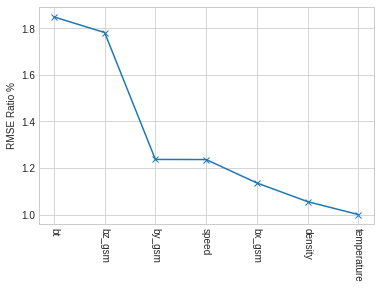

In [23]:
# Visualize the Permutation Importance outcome
plt.plot(rmse_ratio_df.columns, rmse_ratio_df.values.T, 'x-')
plt.xticks(rotation=270)
plt.ylabel('RMSE Ratio %')
plt.grid(True)
plt.show()

### Measure performance in different DST ranges

Although the RMSE gives an indication of model performance, for pratical applications we are mainly interested in accurate predictions during storm events, i.e. when the DST has a large negative value. Below we plot the performance binned by DST ranges.

Unfortunately, it is difficult to accurately estimate performance at extreme times because storm events are very rare. We also show below the number of hourly values in each range; note that since storm events typically last 1-2 days, most of these hours occur very close to each other, and thus do not really represent distinct events.

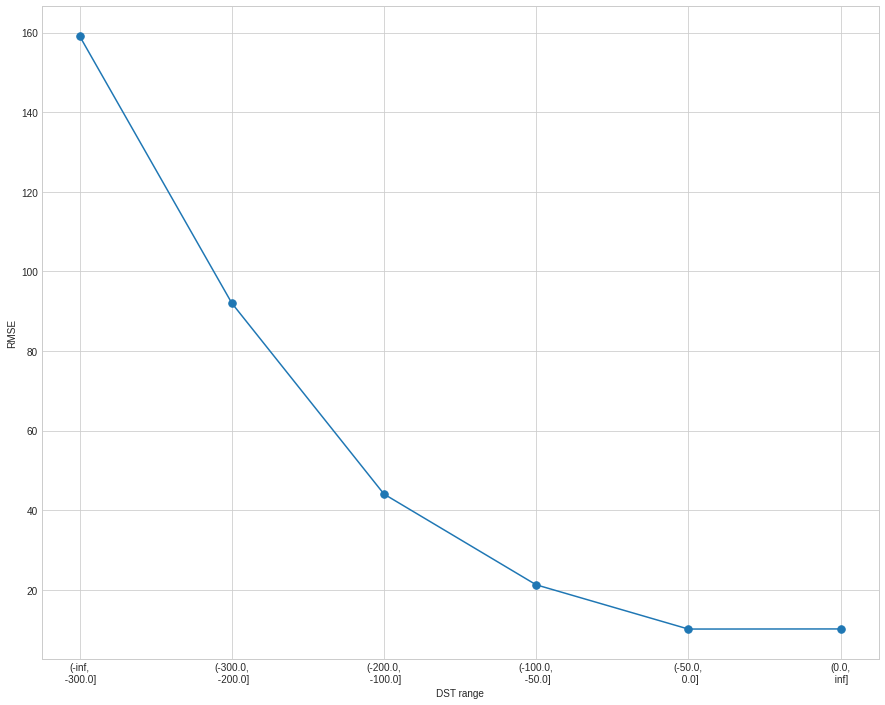

In [24]:
# define plotting function
def plot_binned_RMSE(actual: np.ndarray, predicted: np.ndarray, bin_edges):
    """Produce a plot of RMSE, binned by dst range.

    Args:
        actual: true values of dst
        predicted: predicted values of dst
        bin_edges: edges of the bins by which to group the data
    """

    df = pd.DataFrame({"actual": actual, "predicted": predicted})
    df["bin"] = pd.cut(df["actual"], bin_edges)
    df["sq_err"] = (df["actual"] - df["predicted"]) ** 2
    RMSE_by_bin = np.sqrt(df.groupby("bin")["sq_err"].mean())
    plt.plot(RMSE_by_bin.values, marker='.', markersize=15)
    labels = [s.replace(",", ",\n") for s in RMSE_by_bin.index.astype(str).values]
    plt.xticks(ticks=np.arange(len(RMSE_by_bin)), labels=labels)
    plt.xlabel("DST range")
    plt.ylabel("RMSE")

# plot errors in different DST ranges
plt.figure(figsize=(15, 12))
bins = [-np.inf, -300, -200, -100, -50, 0, np.inf]
plot_binned_RMSE(dst_test_1_min.loc[valid_ind, "dst"].values, dst_test_1_min.loc[valid_ind, "prediction_t"].values, bins)


In [25]:
# size of ranges
bin_id = pd.cut(dst_test_1_min.loc[valid_ind, "dst"], bins).to_frame("bin")
bin_id.groupby("bin").size().to_frame("size")

,size
bin,
"(-inf, -300.0]",17
"(-300.0, -200.0]",33
"(-200.0, -100.0]",436
"(-100.0, -50.0]",2516
"(-50.0, 0.0]",43218
"(0.0, inf]",12454


### Exploring the performance at storm events

Here we plot some graphs showing how the model performs during storm events.

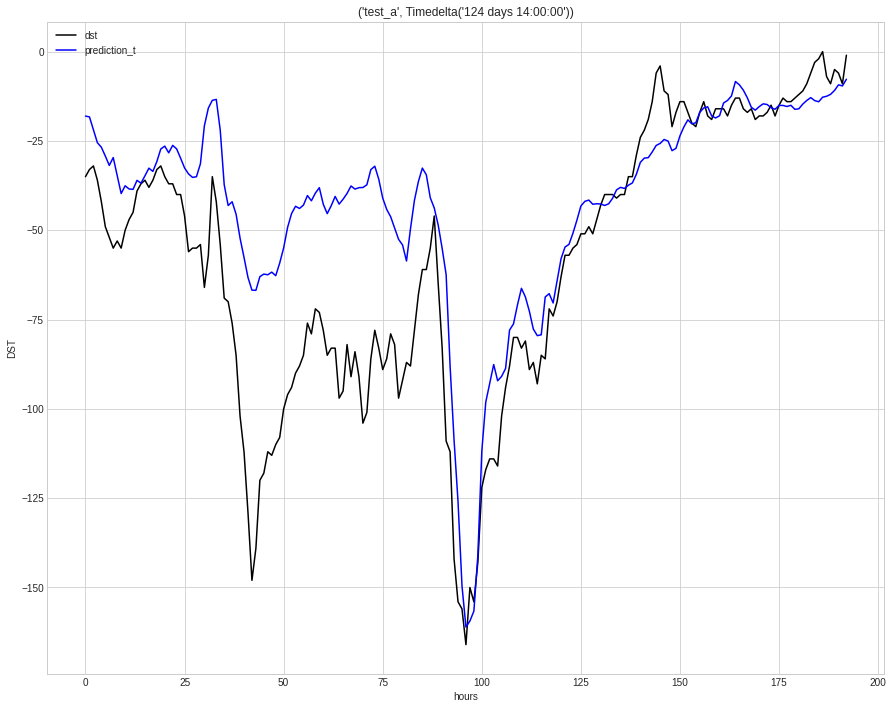

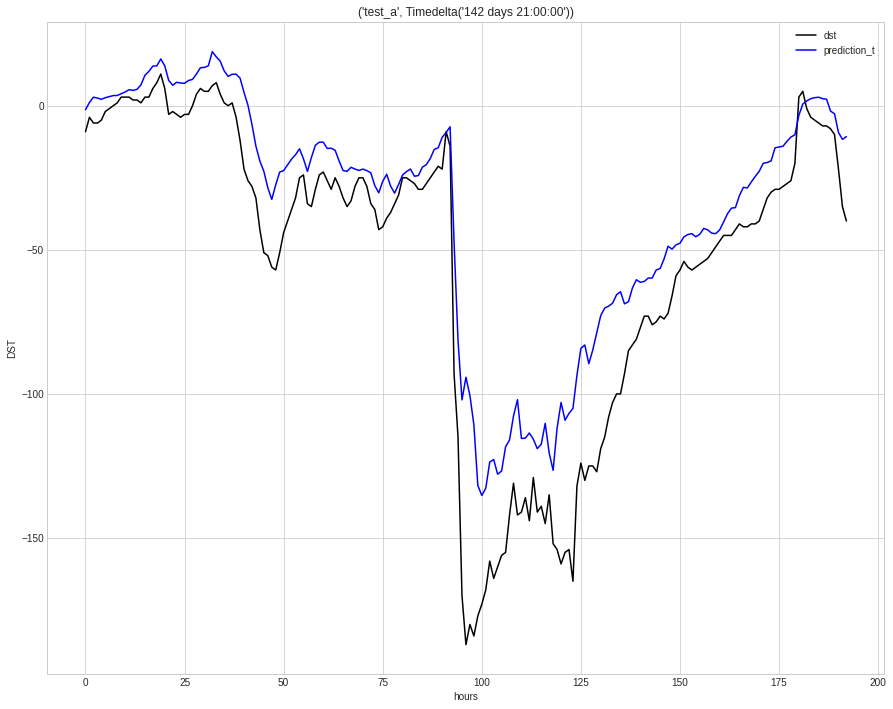

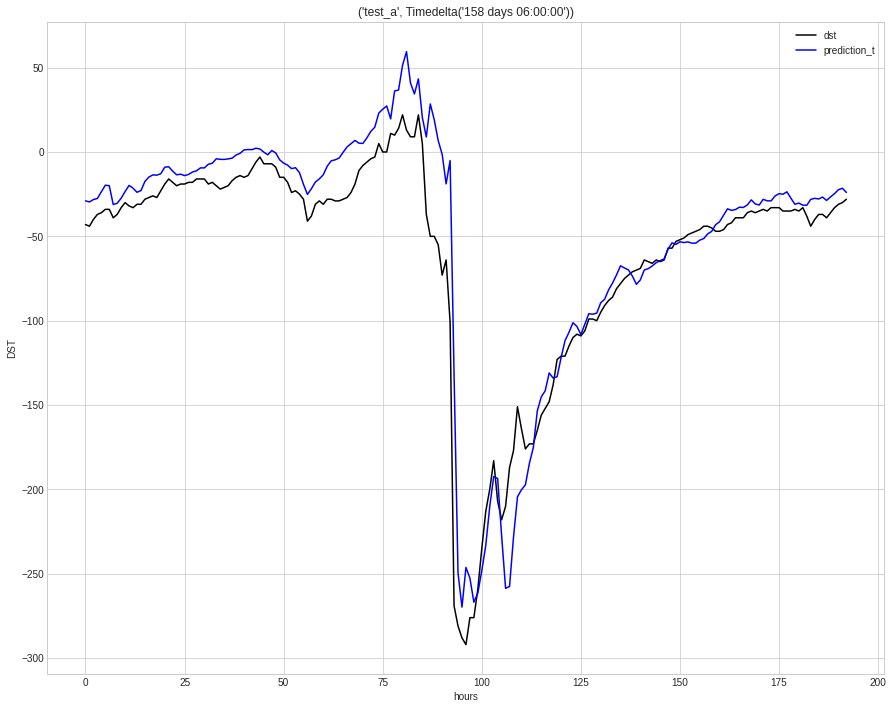

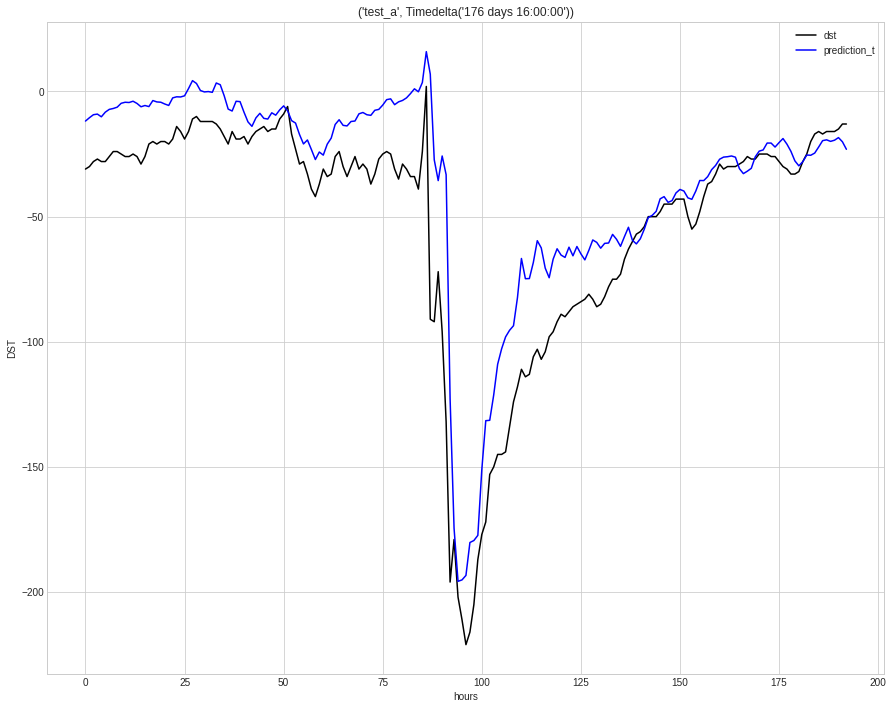

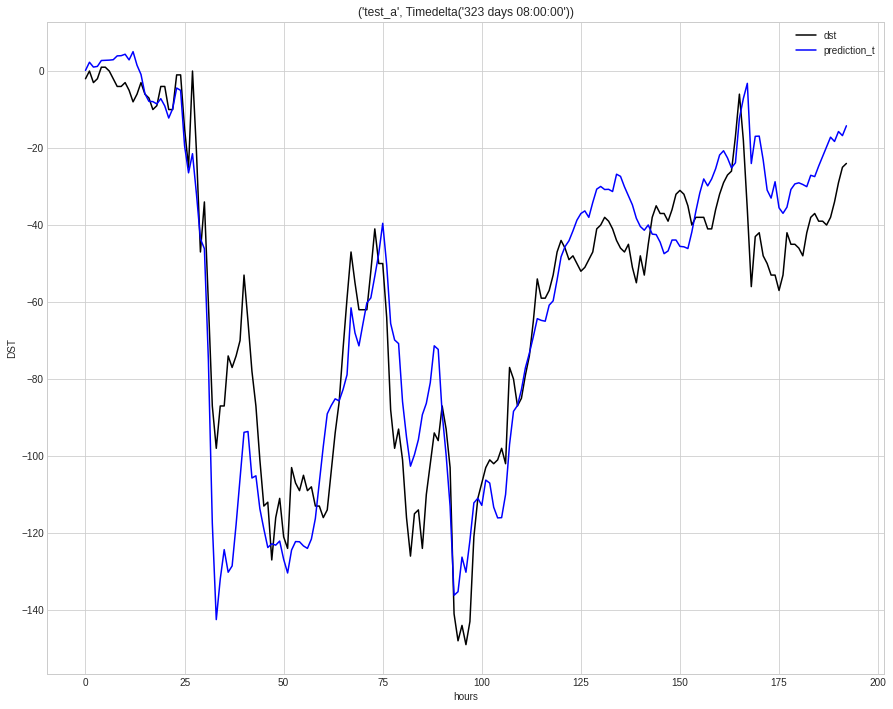

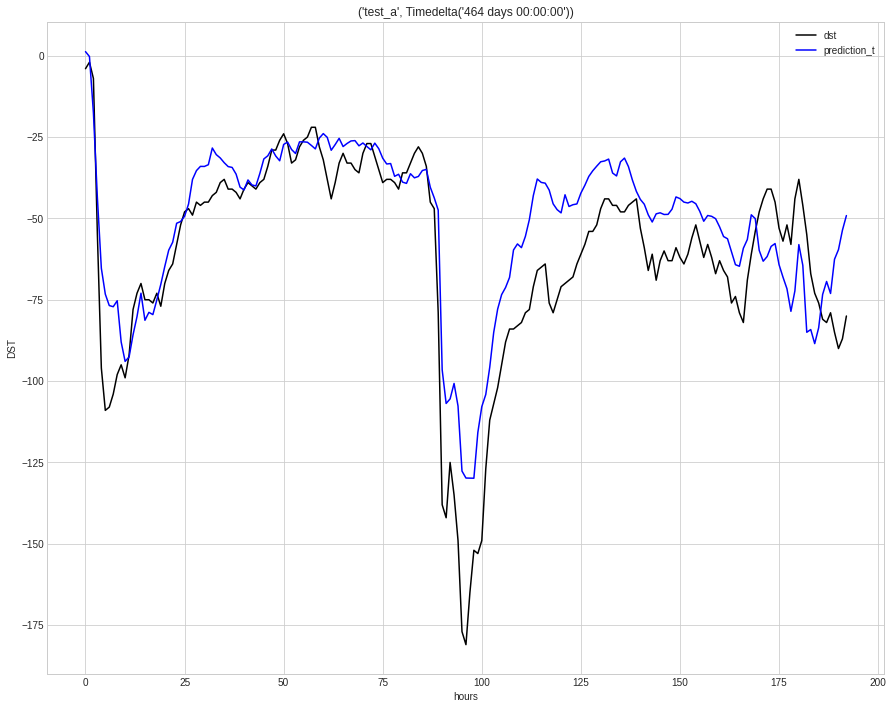

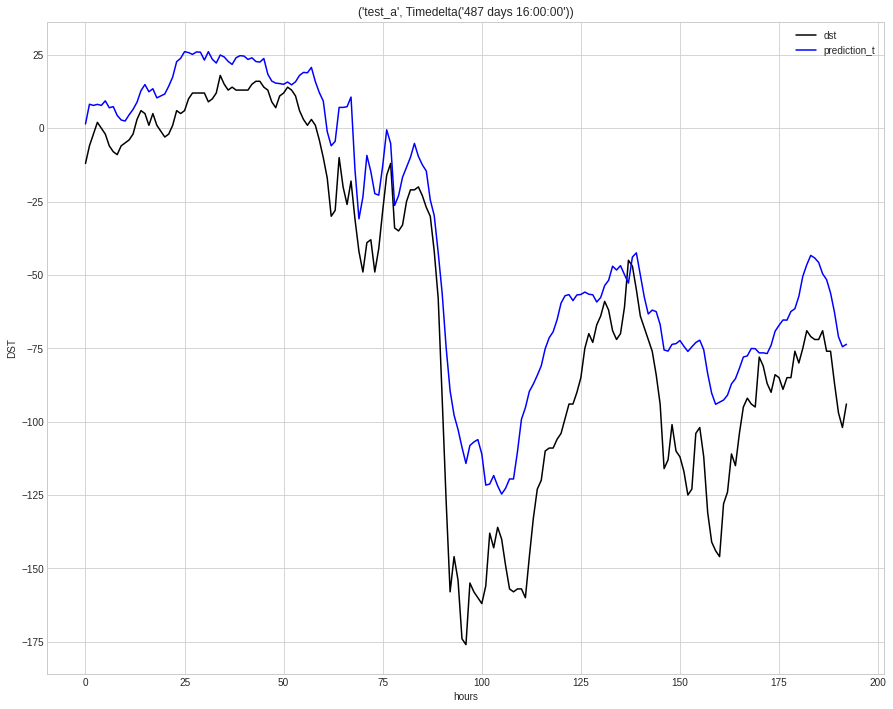

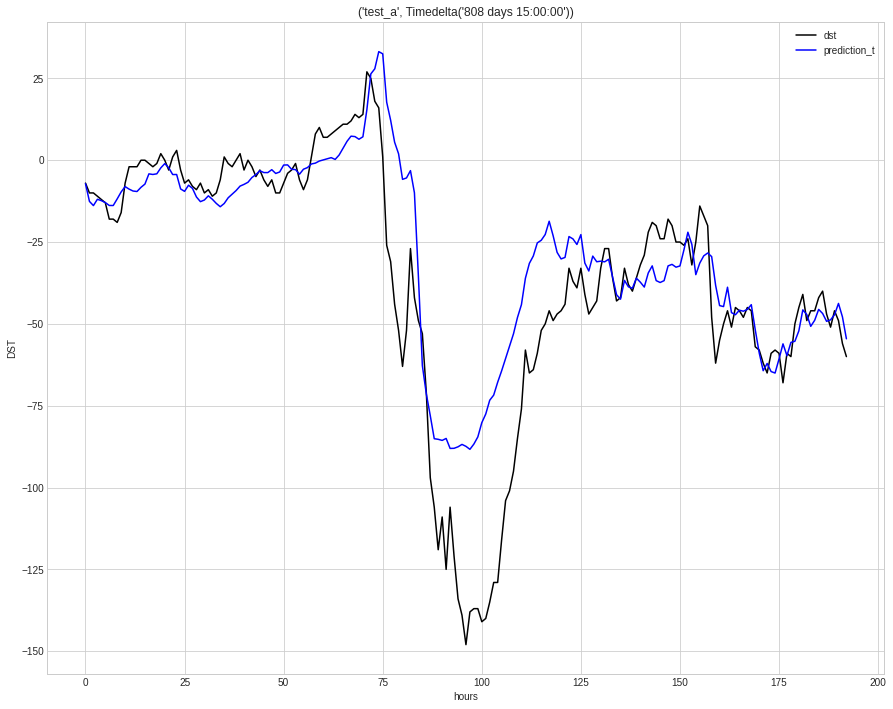

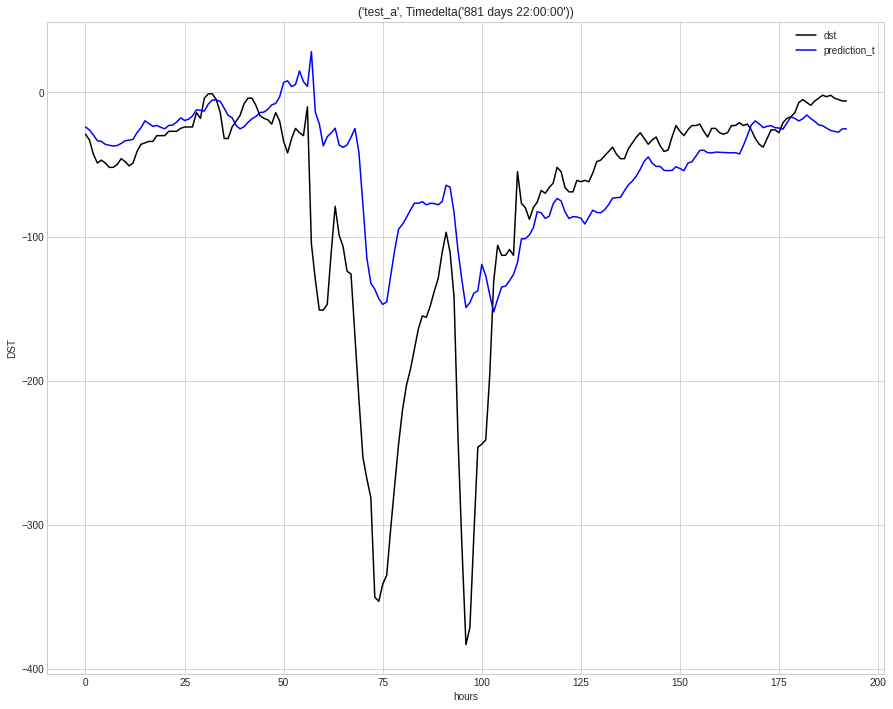

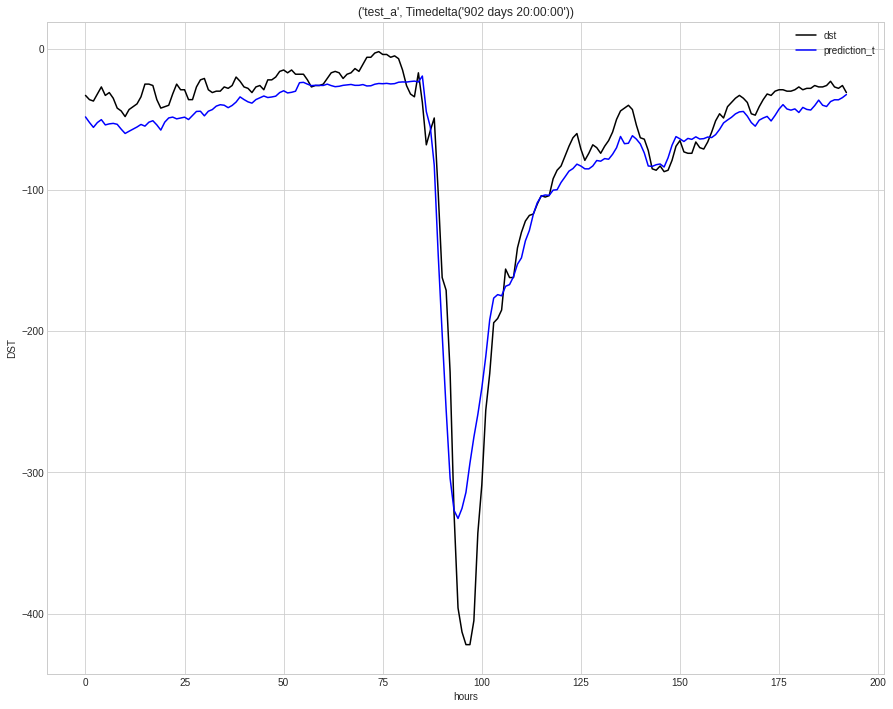

In [26]:
# plot forecast vs actual at storm events
# select events at least 7 days apart
num_events = 10
min_ind_arr = []
min_time_arr = []
labels = []
# dst
dst_test['exclude'] = False
for i in range(num_events):
    min_ind = dst_test.loc[~dst_test['exclude'], 'dst'].idxmin()
    min_time = dst_test.loc[min_ind, ['timedelta', 'period']]
    min_time_arr.append(min_time)
    t, p = min_time['timedelta'], min_time['period']
    min_ind_arr.append(min_ind)
    labels.append(f"{min_time['period'], min_time['timedelta']}")
    dst_test['exclude'] = dst_test['exclude'] | (((dst_test['timedelta'] - t).dt.total_seconds().abs() <= 7 * 24 * 3600) & (dst_test['period'] == p))

# sort by period and timedelta
sort_ind = list(range(num_events))
sort_ind = sorted(sort_ind, key=lambda x: (min_time_arr[x]['period'], min_time_arr[x]['timedelta']))
min_ind_arr = [min_ind_arr[i] for i in sort_ind]
labels = [labels[i] for i in sort_ind]


for i in range(num_events):
    # extract 96 hours before and after max
    ind = min_ind_arr[i]
    # centre on min within 96 * 2 hour window
    new_min = dst_test.loc[ind - 96: ind + 96, 'dst'].idxmin()
    df = dst_test.loc[new_min - 96: new_min + 96].copy()
    df = pd.merge(df, dst_test_1_min[["period", "timedelta", "prediction_t"]], how="left", on=["timedelta", "period"])
    plt.figure(figsize=(15, 12))
    plt.plot(df["dst"].values, c="black")
    plt.plot(df["prediction_t"].values, c="blue")
    plt.legend(["dst", "prediction_t"])
    plt.title(labels[i])
    plt.xlabel("hours")
    plt.ylabel("DST")

